# Import modules 

In [1]:
from pyspark.sql import Window
from pyspark.sql.functions import col,lit,row_number,when,udf,isnan
from pyspark.sql.functions import month,year,to_timestamp
from pyspark.sql.functions import mean,sum,log,min,max,floor,desc,count,stddev_samp,countDistinct
from pyspark.sql.functions import to_date,unix_timestamp,datediff,months_between
from pyspark.sql.functions import dayofmonth,dayofweek,dayofyear,hour,minute,second,lag
from pyspark.sql.functions import regexp_replace,split

#from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param

from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

from pyspark.ml.classification import GBTClassifier
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator


from pyspark.sql.types import StringType,ArrayType,DoubleType,LongType,IntegerType,StructField,StructType
from pyspark.sql import SQLContext,SparkSession,DataFrame

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import make_scorer,accuracy_score,roc_auc_score,confusion_matrix
from sklearn.metrics import roc_curve, auc

import sys
from hyperopt import fmin, tpe, hp
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import math
import git

%matplotlib inline


plt.rcParams['font.size']= 12
plt.rcParams["font.family"] = "Times New Roman"

# find the working path
working_path = os.getcwd()

# Define auxiliary functions

In [2]:
def col_replace(df,col_name,to_replace,value,data_type,*args):
    """
    Function to replace to replace a part of a string in a columns with another value 
    and also change the data type of the column. By default overwrite the existing column
    unless a new column name is provided.
    """
    if args:
        new_col_name = args[0]
    else:
        new_col_name = col_name
    df = df.withColumn(new_col_name,regexp_replace(df[col_name],to_replace,value).astype(data_type))
    return df

def ageInDays(df,end,start='transactionDateTime'):
    """
    Function to calculate the number of days between a given column and transactionDateTime and
    save it as a new column in the dataframe. This will tell us e.g the tenure age of the account
    at the time of transaction. 
    """
    return df.withColumn(end + '_age',datediff(col(start),col(end)))




# Initiate spark

In [3]:
spark = SparkSession.builder.appName("fraud_model").getOrCreate()

# Automatically download and load the data

In [4]:
# read the data
df = spark.read.json(working_path + '/transactions.txt')

# Changing the schema (data types)
Note that for transactionDateTime, there are 61 rows that contain times which can not exists. 
That is due to Daylight Saving. e.g. on November 6, 2016 it is impossible to have 2:15 AM EST because
daylight saving happens at 2 am. This can be caused by error in data collection or may be the reported 
time is in another timezone. By setting the data type of that column to timestamp, pyspark autmatically shift the time by one hour, otherwise we would have nulls for these incidents. 

In [5]:
# data type for all collumns is string. We have to change that for numerical and date columns.
corrected_schema = {'accountNumber':LongType(),
                   'cardCVV':IntegerType(),
                    'cardLast4Digits':IntegerType(),
                    'customerId':LongType(),
                    'enteredCVV':IntegerType(),
                    'recurringAuthInd':IntegerType(),
                    'posOnPremises':IntegerType(),
                    'merchantZip':IntegerType(),
                    'merchantState':IntegerType(),
                    'merchantCity':IntegerType(),
                    'transactionDateTime':'timestamp'
                   }

# date columns
date_format = {'accountOpenDate':'yyyy-MM-dd',
               'dateOfLastAddressChange':'yyyy-MM-dd',
               'currentExpDate':'MM/yyyy'
#                'transactionDateTime':"yyyy-MM-dd'T'H:mm:ss"
              }


# apply the correct data type
for c in date_format.keys():
    df = df.withColumn(c,to_timestamp(df[c],format=date_format[c]))

for c in corrected_schema.keys():
    df = df.withColumn(c,col(c).cast(corrected_schema[c]))
    

# Creating a list of date columns
date_colummns = []
for x,y in df.dtypes:
    if y == 'timestamp':
       date_colummns.append(x) 


# Statistics

In [6]:
print('Number of records = {:d}'.format(df.count()))
print('Number of columns = {:d}'.format(len(df.columns)))
print('Number of fradulent transactions = {:d} ({:4.2f}% of total transactions)'
      .format(df.filter(df.isFraud==1).count(),
             df.filter(df.isFraud==1).count()*100/df.count()
             )
     )
print('Number of fradulent transactions with merchantCategoryCode of online_retail = {:d} ({:4.2f}% of total fraud) '
      .format(df.filter((df.isFraud==1) &
                        (df.merchantCategoryCode=='online_retail')
                       ).count(),
              df.filter((df.isFraud==1) &
                        (df.merchantCategoryCode=='online_retail')
                       ).count()*100/df.filter(df.isFraud==1).count()
             )
     )


Number of records = 641914
Number of columns = 29
Number of fradulent transactions = 11302 (1.76% of total transactions)
Number of fradulent transactions with merchantCategoryCode of online_retail = 3647 (32.27% of total fraud) 


In [7]:
# to check if a customerId can have more than two accountNumber 
dc = df.groupBy('customerId').agg(countDistinct('accountNumber').alias('c'))
print('Number of customerId with more than one accountNumber: {:d}'.format(dc.filter(dc.c>1).count()))

Number of customerId with more than one accountNumber: 0


In [8]:
# count the number of distinct values for each columns
for c in df.columns:
    print(c,df.select(c).distinct().count())

accountNumber 5000
accountOpenDate 1826
acqCountry 5
availableMoney 450690
cardCVV 899
cardLast4Digits 5134
cardPresent 2
creditLimit 10
currentBalance 406990
currentExpDate 165
customerId 5000
dateOfLastAddressChange 2186
echoBuffer 1
enteredCVV 980
expirationDateKeyInMatch 2
isFraud 2
merchantCategoryCode 19
merchantCity 1
merchantCountryCode 5
merchantName 2493
merchantState 1
merchantZip 1
posConditionCode 4
posEntryMode 6
posOnPremises 1
recurringAuthInd 1
transactionAmount 62735
transactionDateTime 635472
transactionType 4


In [9]:
# calculating max and min of each column
dk = df.groupBy().agg(*[max(col(c)) for c in df.columns],
                      *[min(col(c)) for c in df.columns],
                      *[mean(col(c)) if y!='string' and y!='boolean' and y!='timestamp' else lit(0) for c,y in df.dtypes]
                     ).toPandas()
dk.transpose()

,0
max(accountNumber),999985343
max(accountOpenDate),2015-12-31 00:00:00
max(acqCountry),US
max(availableMoney),50000
max(cardCVV),998
max(cardLast4Digits),9998
max(cardPresent),True
max(creditLimit),50000
max(currentBalance),47496.5
max(currentExpDate),2032-01-01 00:00:00


## Distribution of transactionAmount

In [10]:
print('Percentage of transactionAmount less than $100: {:4.2f}%'.format(
    df.filter(df.transactionAmount<100).count()*100/df.count())
     )

Percentage of transactionAmount less than $100: 54.59%


In [11]:
# convert to pandas
dt = df.select('transactionAmount','isFraud').toPandas()

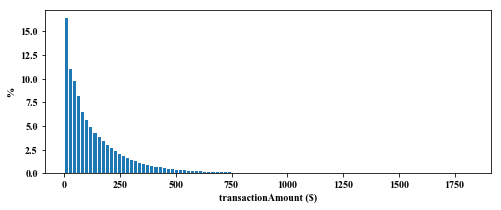

In [12]:
# distribution of transactionAmount
fig = plt.figure(1)
ax = fig.add_subplot(111)
dt['transactionAmount'].hist(bins=100,
                            weights=np.ones_like(dt['transactionAmount'])*100./len(dt),
                            rwidth = 0.75,
                            grid = False,
                            ax = ax)
# ax.set_xlim([0,24])
ax.set_xlabel('transactionAmount ($)')
ax.set_ylabel('%')
fig.set_size_inches(8,3)
fig.savefig('transactionAmount_dist.png',bbox_inches='tight',format='png',dpi=600)

In [13]:
# calculate the log of transactionAmount
dt['transactionAmountLog'] = np.log(dt.transactionAmount)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


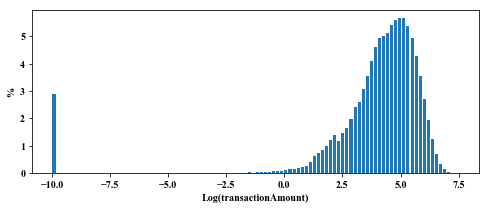

In [14]:
# distribution of transactionAmountLog (replaced the log(0) with -10)
fig = plt.figure(1)
ax = fig.add_subplot(111)
dt.loc[dt.transactionAmount==0,'transactionAmountLog'] = -10
dt['transactionAmountLog'].hist(bins=100,
                            weights=np.ones_like(dt['transactionAmountLog'])*100./len(dt),
                            rwidth = 0.75,
                            grid = False,
                            ax = ax)
ax.set_xlabel('Log(transactionAmount)')
ax.set_ylabel('%')
fig.set_size_inches(8,3)
fig.savefig('transactionAmountLog_dist.png',bbox_inches='tight',format='png',dpi=600)

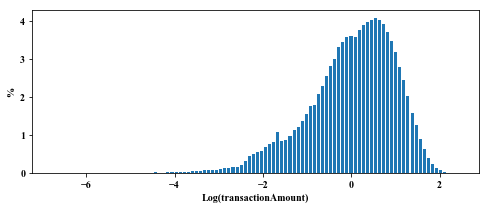

In [15]:
# distribution of transactionAmountLog (removed transactionAmount=0)

fig = plt.figure(1)
ax = fig.add_subplot(111)
dt['transactionAmountLogStandard'] = (dt['transactionAmountLog'].loc[dt.transactionAmount!=0]-
                                      np.mean(dt['transactionAmountLog'].loc[dt.transactionAmount!=0]))/np.std(dt['transactionAmountLog'].loc[dt.transactionAmount!=0])
dt['transactionAmountLogStandard'].loc[dt.transactionAmount!=0].hist(bins=100,
                            weights=np.ones_like(dt['transactionAmountLogStandard'].loc[dt.transactionAmount!=0])*100./len(dt.loc[dt.transactionAmount!=0]),
                            rwidth = 0.75,
                            grid = False,
                            ax = ax)
# ax.set_xlim([0,24])
ax.set_xlabel('Log(transactionAmount)')
ax.set_ylabel('%')
fig.set_size_inches(8,3)
fig.savefig('transactionAmountLog_dist.png',bbox_inches='tight',format='png',dpi=600)

In [16]:
print('Kurtosis for log of transactionAmount = {:4.2f}'
      .format(dt['transactionAmountLogStandard'].loc[dt.transactionAmount!=0].kurtosis()))
print('Skew for log of transactionAmount = {:4.2f}'
      .format(dt['transactionAmountLogStandard'].loc[dt.transactionAmount!=0].skew()))


Kurtosis for log of transactionAmount = 1.43
Skew for log of transactionAmount = -0.93


# Nulls

In [6]:
# Count the nulls.
# Create a list of columns with more than 30% nulls
# Create a null map dict. For each columns it provides the value that replaces the null. 
n = df.count()
print('Number of samples: {:d} \n\n'.format(n))
print('column_name,data_type,null_count,null_percentage \n')
col_count = 0
remove_cols = []
null_map = {}
for c,y in df.dtypes:
    if y == 'string':
        null_cnt = df.filter(df[c]=='').count()  # for string columns, empty is considered as null
    else:
        null_cnt = df.filter(df[c].isNull()).count()

    if  null_cnt> 0:
        col_count += 1
        if math.floor(null_cnt*1./n*100) > 30:
            remove_cols.append(c)
        elif y == 'string' :
            null_map[c] = 'unknown'  # for string columns, empty rows will be replaced by "unknown"
        print('{:s},{:s},{:d},{:d}% \n'.format(c,y,null_cnt,math.floor(null_cnt*1./n*100)))

print('\nThere are {:d} columns with null values. \n\n'.format(col_count))

# Among the columns with null (empty) values that we are going to keep all have string data type.
# We just replace the empty rows of those columns with the value in null_map ("unknown").
for c in null_map.keys():
    df = df.withColumn(c,when(col(c)=='',null_map[c]).otherwise(col(c)))

# Creating a list of columns that we will keep (removing columns with more than 30% null/empty)
keep_cols = []
for c in df.columns:
    if c not in remove_cols:
        keep_cols.append(c)

# Removing the columns from the data frame
df = df.select(keep_cols)


Number of samples: 641914 


column_name,data_type,null_count,null_percentage 

acqCountry,string,3913,0% 

echoBuffer,string,641914,100% 

merchantCity,int,641914,100% 

merchantCountryCode,string,624,0% 

merchantState,int,641914,100% 

merchantZip,int,641914,100% 

posConditionCode,string,287,0% 

posEntryMode,string,3345,0% 

posOnPremises,int,641914,100% 

recurringAuthInd,int,641914,100% 

transactionType,string,589,0% 


There are 11 columns with null values. 




# Duplicates

In [7]:
# Finding duplicate and reversal transactions:
# By using a window which is partiotned by accountNumber and sorted by transactionDateTime
# we create a column for the time difference (in seconds) between two consecutive 
# transactions in an account.
w = Window.partitionBy('accountNumber').orderBy('transactionDateTime')
df = df.withColumn('transactionDateTime_prev',lag(df.transactionDateTime).over(w))  # time of previous transaction

df = df.withColumn('diffD',
                   datediff(df.transactionDateTime,df.transactionDateTime_prev))

df = df.withColumn('diffH',
                   df.diffD*24+      # days
                   (hour(df.transactionDateTime)-hour(df.transactionDateTime_prev)))

df = df.withColumn('diffS',
                   datediff(df.transactionDateTime,df.transactionDateTime_prev)*24*3600+      # days
                   (hour(df.transactionDateTime)-hour(df.transactionDateTime_prev))*3600+     # hours
                   (minute(df.transactionDateTime)-minute(df.transactionDateTime_prev))*60+   # minutes
                   (second(df.transactionDateTime)-second(df.transactionDateTime_prev))       # seconds
                  )


for c in ['diffD','diffH','diffS']:
    df = df.withColumn(c,when(col(c).isNull(),0).otherwise(col(c)))

# Using the same window we create a column for prvious transaction's amount
df = df.withColumn('transactionAmount_prev',lag(df.transactionAmount).over(w))

# If two consecutive transactions occured in lass than 5 minutes and their amount is the same
# they are considered as repeated.
# Here, the first transaction isn't flagged as repeated.
df = df.withColumn('isRepeated',
                  when((df.diffS<300) &
                      (df.transactionAmount==df.transactionAmount_prev),
                      1).otherwise(0))


## Number of swipes in duplicate transactions

In [8]:
df = df.withColumn('XORrepeated',df.isRepeated.bitwiseXOR(1)) # flag not duplicate

# window partitioned by accountNumber and ordered by transactionDateTime
w1 = Window.partitionBy('accountNumber').orderBy('transactionDateTime')

# new data frame (dg); create a dummy variable 
df = df.withColumn('subgroup',sum(df.XORrepeated).over(w1))

df = df.withColumn('availableMoneyNext',lag(df.availableMoney,-1).over(w1))
df = df.withColumn('availableMoneyPrev',lag(df.availableMoney).over(w1))

# window partitioned by accountNumber and the dummy variable 
w2 = Window.partitionBy('accountNumber','subgroup')
# count the number of swipes in each duplicate transaction
df = df.withColumn('duplicateCounter',count(df.XORrepeated).over(w2))
# flag reverse transactions where the availableMoney doesn't change
df = df.withColumn('isReverse',
                  when((df.duplicateCounter>1) &
                       (df.availableMoneyNext==df.availableMoneyPrev),
                       1).otherwise(0))

df = df.withColumn('isReverseNext',lag(df.isReverse,-1).over(w1))
print('Number of reversed transactions: {:d} '.format(df.filter(df.isReverse==1).count()))
print('Amount of reversed transactions: ')
df.filter(df.isReverse==1).groupby().agg(sum(col('transactionAmount'))).show()

# If two consecutive transactions occured in lass than 5 minutes and their amount is the same
# and the transaction is not reversed that is considered as multiple swipe or duplicated.
# Here, the first transaction isn't flagged as duplicated.
df = df.withColumn('isDuplicate',
                  when((df.diffS<300) &
                      (df.transactionAmount==df.transactionAmount_prev) &
                       (df.isReverse==0),
                      1).otherwise(0))

print('\nNumber of duplicate transactions: {:d}'.format(df.filter(df.isDuplicate==1).count()))
print('Amount of duplicate transactions: ')
df.filter(df.isDuplicate==1).groupby().agg(sum(col('transactionAmount'))).show()
# keep only those which swiped more than once
df1 = df.filter((df.duplicateCounter>1))
# window partitioned by accountNumber and dummy variable orderd by transactionDateTime
w3 = Window.partitionBy('accountNumber','subgroup').orderBy('transactionDateTime')
# keep only the first duplicate transaction
df1 = df1.withColumn("rn",row_number().over(w3)).filter("rn == 1")

print('Total transactionAmount after removing duplicate transactions:')
df.filter((df.isDuplicate==0)).groupby().agg(sum(df.transactionAmount)).show()

Number of reversed transactions: 4197 
Amount of reversed transactions: 
+----------------------+
|sum(transactionAmount)|
+----------------------+
|     552246.8199999997|
+----------------------+


Number of duplicate transactions: 6477
Amount of duplicate transactions: 
+----------------------+
|sum(transactionAmount)|
+----------------------+
|     986478.9300000003|
+----------------------+

Total transactionAmount after removing duplicate transactions:
+----------------------+
|sum(transactionAmount)|
+----------------------+
|   8.577622015999995E7|
+----------------------+



In [9]:
df1 = df1.withColumn('transactionAmount_Duplicate',df1.transactionAmount*(df.duplicateCounter-1))
dg = df1.select('duplicateCounter','transactionAmount_Duplicate').toPandas()

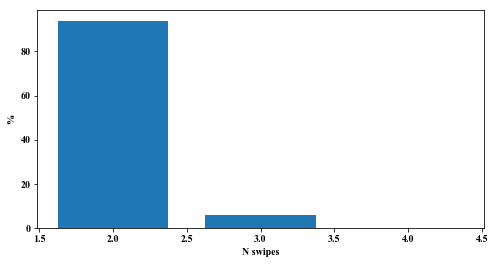

In [21]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
dg['duplicateCounter'].hist(bins=[1.5,2.5,3.5,4.5],
                            weights=np.ones_like(dg['duplicateCounter'])*100./len(dg),
                            rwidth = 0.75,
                            grid = False,
                            ax = ax)
# ax.set_xlim([0,24])
ax.set_xlabel('N swipes')
ax.set_ylabel('%')
fig.set_size_inches(8,4)

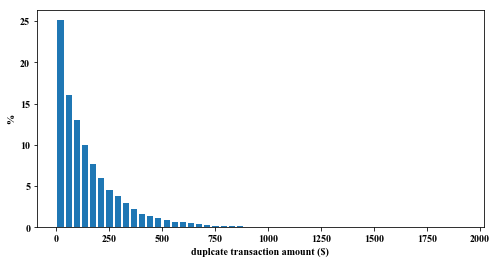

In [22]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
dg['transactionAmount_Duplicate'].hist(bins=50,
                            weights=np.ones_like(dg['transactionAmount_Duplicate'])*100./len(dg),
                            rwidth = 0.75,
                            grid = False,
                            ax = ax)
# ax.set_xlim([0,24])
ax.set_xlabel('duplcate transaction amount ($)')
ax.set_ylabel('%')
fig.set_size_inches(8,4)

# Data structure and histograms

In [23]:
# remove duplicate transactions
df = df.filter(df.isDuplicate==0)

In [24]:
nfraud = df.filter(df.isFraud==1).count()
ntransactions = df.count()

print('Total number of transactions: {:d}'.format(df.count()))
print('Total number of fraudulant transactions: {:d}'.format(nfraud))
print('Number of consecutive transactions with time diff less than 1 day: {:d} ({:d}% of total)'
      .format(df.filter(df.diffD<1).count(),df.filter(df.diffD<1).count()*100//ntransactions))
print('Number of consecutive transactions with time diff more than 10 days: {:d} ({:d}% of total) \n'
      .format(df.filter(df.diffD>10).count(),df.filter(df.diffD>10).count()*100//ntransactions))

dummy = df.filter((df.diffD<1) & (df.isFraud==1)).count()
print('Number of fraudulent transactions with time diff less than 1 day: {:d} ({:d}% of fraud cases)'
      .format(dummy,dummy*100//nfraud))

dummy = df.filter((df.diffD<10) & (df.isFraud==1)).count()
print('Number of fraudulent transactions with time diff less than 10 days: {:d} ({:d}% of fraud cases)'
      .format(dummy,dummy*100//nfraud))


dummy = df.filter((df.isDuplicate==1) & (df.isFraud==1)).count()
print('Number of duplicate and fraudulent transactions: {:d} ({:d}% of fraud cases)'
      .format(dummy,dummy*100//nfraud))



Total number of transactions: 635437
Total number of fraudulant transactions: 11160
Number of consecutive transactions with time diff less than 1 day: 272974 (42% of total)
Number of consecutive transactions with time diff more than 10 days: 38089 (5% of total) 

Number of fraudulent transactions with time diff less than 1 day: 5135 (46% of fraud cases)
Number of fraudulent transactions with time diff less than 10 days: 10669 (95% of fraud cases)
Number of duplicate and fraudulent transactions: 0 (0% of fraud cases)


In [25]:
dg = df.select(['diffS','diffD','diffH','isFraud']).toPandas()

## Distribution of days between two consecutive transactions

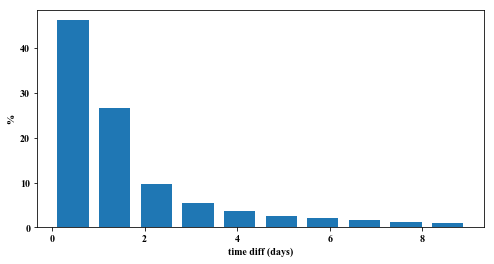

In [26]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
dg['diffD'].loc[ (dg.diffD<10)].hist(bins=10,
                    weights=np.ones_like(dg['diffD'].loc[ (dg.diffD<10)])*100./len(dg.loc[ (dg.diffD<10)]),
                    rwidth = 0.75,
                    grid = False,
                    ax = ax)
# ax.set_xlim([0,24])
ax.set_xlabel('time diff (days)')
ax.set_ylabel('%')
fig.set_size_inches(8,4)

## Distribution of hours between two consecutive transactions (in one day)

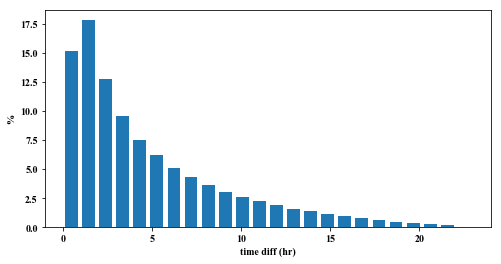

In [27]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
dg['diffH'].loc[dg.diffD<1].hist(bins=24,
                    weights=np.ones_like(dg['diffH'].loc[dg.diffD<1])*100./len(dg.loc[dg.diffD<1]),
                    rwidth = 0.75,
                    grid = False,
                    ax = ax)
# ax.set_xlim([0,24])
# ax.set_ylim([0,20])

ax.set_xlabel('time diff (hr)')
ax.set_ylabel('%')
fig.set_size_inches(8,4)

# Feature engineering

In [10]:
# Creating 4 new features for transactionDateTime.
# hour, dayOfWeek,dayOfMonth and dayOfYear
# Creating the age column for other date columns. (ref to ageInDays function)
for c in date_colummns:
    if c == 'transactionDateTime':
        df = df.withColumn(c + '_hour',hour(col(c)))
        df = df.withColumn(c + '_dayOfWeek',dayofweek(col(c)))
        df = df.withColumn(c + '_dayOfMonth',dayofmonth(col(c)))
        df = df.withColumn(c + '_dayOfYear',dayofyear(col(c)))
    else:
        df = ageInDays(df,c)

# Creating a new column for transactionDateTime which divides the time of 
# transaction to 4 categories: morning, afternoon, night and midnight
c = 'transactionDateTime' 
df = df.withColumn(c + '_timeOfDay',
                           when(col(c+'_hour')<8,'midnight').otherwise(
                               when(col(c+'_hour')<12,'morning').otherwise(
                                   when(col(c+'_hour')<18,'afternoon').otherwise('night')
                               )
                           )
                          )

In [11]:
# Creating a z-score for tranactionAmount at customer level
# window partitioned by customerId
w = Window.partitionBy('customerId')
# calculate the z-score
df = df.withColumn('transactionAmount_z',
                   (df.transactionAmount-mean(df.transactionAmount).over(w))/stddev_samp(df.transactionAmount).over(w))
# replace the null and nan with zero (null means the stddev is zero and nan means there is only one transactions)
df = df.withColumn('transactionAmount_z',when((df.transactionAmount_z.isNull()) 
                                              | isnan(df.transactionAmount_z),0).otherwise(df.transactionAmount_z))

# Creating a new column to flag the mismath between cardCVV and enteredCVV
df = df.withColumn('CVVinMatch',when(df.cardCVV==df.enteredCVV,1).otherwise(0))

# Creating a new column to flag the mismath between merchanCountryCode and acqCountry
df = df.withColumn('countryinMatch',when(df.acqCountry==df.merchantCountryCode,1).otherwise(0))



In [12]:
# Count the number of distinct values for string (categorical columns)
# replace boolean with 1/0
print('Number of unique values for each categorical feature: \n')
for x,y in df.dtypes:
#     if y=='string':
#         print('{:s} {:d}'.format(x,df.select(x).distinct().count()))
    if y=='boolean':
        df = df.withColumn(x,when(df[x]==True,1
                                 ).otherwise(0))

Number of unique values for each categorical feature: 



In [13]:
# Number of distinct values for merchantName is too high to use OneHotEncoder.
# merchantName contains a brand name like CVS follwed by a number that probably 
# is indicator of the store number. 
# First we create a new column (merchantName_main) which only contains the brand name.
df = col_replace(df,'merchantName',r' (#)(\d+)','','string','merchantName_main')


# We replace accountNumber, merchanName and merchantName_main columns with Weight of Evidence (WEO).
TP = df.agg(*[sum(df.isFraud).alias('sum_isFraud')]).collect()[0]['sum_isFraud']  # total number of positives (frauds)
TN = df.count()-TP                                                                # total number of negatives (not fraud)

# for each distinct value we calculate the number of positives and negatives and 
# finally calculate the WOE
for c in ['merchantName','merchantName_main','accountNumber']:
    w = Window.partitionBy(c) 
    df = df.withColumn(c + '_P',when(sum(df.isFraud).over(w)!=0,sum(df.isFraud).over(w)).otherwise(0.01)) 
    df = df.withColumn(c + '_N',count(df.isFraud).over(w)-col(c+'_P'))
    df = df.withColumn(c,log((col(c+'_P')/TP)/(col(c+'_N')/TN)))

df = df.fillna({'accountNumber':1e10})

In [14]:
# create a list of categorical and numerical columns
cat_cols = []
num_cols = []
for x, y in df.dtypes:
    if y == 'string':
        cat_cols.append(x)
    elif y != 'timestamp':
        num_cols.append(x)


# replace the nulls in diffS column with zero (diffS only for the first transction in 
# each partition is null so it makes sense to replace them with zero)
df = df.fillna({'diffS': 0})

label = 'isFraud'             # target column

# columns that we are going to remove from the training dataset:
# the target columns
# unique identifiers
# columns with only one distinct value
# dummy columns that we created for previous transformations
num_cols_toRemove = ['isFraud', 
                     'cardCVV', 'cardLast4Digits', 
                     'customerId', 'enteredCVV',
                     'transactionAmount_prev', 'isDuplicate','XORduplicate',
                     'diffD','diffS','subgroup','duplicateCounter',
                     'accountNumber_P','accountNumber_N',
                     'merchantName_P','merchantName_N',
                     'merchantName_main_P','merchantName_main_N'
                    ]

# Finall list of numerical columns that we use in training
num_cols = [x for x in num_cols if x not in num_cols_toRemove]

# Make sure that the dependent variable is not in the list of independent varibales
assert label not in num_cols


# Pipeline

In [15]:
# Creating index for categorical columns
cat_indexers = [StringIndexer(inputCol = x, outputCol = x + '_Index') for x in cat_cols]

# Creating OneHotEncoder for categorical columns
encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),
                          outputCol=indexer.getOutputCol() + '_Encoded')
            for indexer in cat_indexers ]

# Creating assembler (Assemble onehotencoder with numerical columns)
assembler = VectorAssembler(inputCols=
                            [encoder.getOutputCol() for encoder in encoders] + 
                            num_cols,
                            outputCol='features')

# Creating stages 
stages = cat_indexers + encoders + [assembler]

# Creatinf pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the pipeline
pipeline = pipeline.fit(df)
df = pipeline.transform(df)


End of Transformations

# Training model

Here I am going to use XGBoost python API to train the model.

Here we have used hyperopt package for hyper parameter tuning.


In [ ]:
# convert to pandas dataframe
pandaDf = df.select(['features',label]).toPandas()
y = pandaDf[label].values.reshape(-1,1)
series = pandaDf['features'].apply(lambda x : np.array(x.toArray())).as_matrix().reshape(-1,1)
features = np.apply_along_axis(lambda x : x[0], 1, series)

# split to train and test set
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42)

# convert to DMatrix
dtrain = xgb.DMatrix(X_train,y_train)
dtest = xgb.DMatrix(X_test,y_test)

In [34]:
print('learning_rate,min_child_weight,subsample,colsample_bytree,reg_lambda,reg_alpha,scale_pos_weight,n_estimators,max_depth,rate_drop,test_auc_mean \n')

def sample_loss(args):
    """
    The function that hyperopt will minimize. It returns (1-auc), hence minimizing it equivalent to maximizing
    auc. We have used XGBoost cross validation with 3 folds.
    """
    max_depth,scale_pos_weight,min_child_weight,n_estimators,learning_rate,subsample,colsample_bytree,reg_lambda,reg_alpha,rate_drop = args
    print('{:4.6f},{:4.6f},{:4.6f},{:4.6f},{:4.6f},{:4.6f},{:4.6f},{:d},{:d},{:4.6f},'
          .format(learning_rate,min_child_weight,subsample,
                  colsample_bytree,reg_lambda,reg_alpha,
                  scale_pos_weight,n_estimators,max_depth,rate_drop),end='')
    param = {'max_depth':max_depth,
             'scale_pos_weight':scale_pos_weight,
             'min_child_weight':min_child_weight,
             'n_estimators':n_estimators,
             'learning_rate':learning_rate,
             'subsample':subsample,
             'colsample_bytree':colsample_bytree,
             'reg_lambda':reg_lambda,
             'reg_alpha':reg_alpha,
             'booster':'dart',
             'rate_drop':rate_drop
            }
    cv_score = xgb.cv(param,dtrain, param['n_estimators'], nfold=3, metrics={'auc'}, seed=0)
    print('{:4.6f} \n'.format(cv_score.iloc[-1]['test-auc-mean']))
    return 1-cv_score.iloc[-1]['test-auc-mean']

space =[
    hp.uniformint('max_depth',3,30),
    hp.uniform('scale_pos_weight',1,60),
    hp.uniform('min_child_weight',1,10),
    hp.uniformint('n_estimators',5,100),
    hp.loguniform('learning_rate',np.log(0.01),np.log(0.3)),
    hp.uniform('subsample',0.6,1),
    hp.uniform('colsample_bytree',0.6,1),
    hp.loguniform('reg_lambda',np.log(0.00001),np.log(100)),
    hp.loguniform('reg_alpha',np.log(0.00001),np.log(100)),
    hp.loguniform('rate_drop',np.log(0.01),np.log(0.3))
]

best_xgb = fmin(sample_loss,
           space = space,
           algo=tpe.suggest,
           max_evals=25)  # Here I have only used 25 so the cell run faster.



learning_rate,min_child_weight,subsample,colsample_bytree,reg_lambda,reg_alpha,scale_pos_weight,n_estimators,max_depth,rate_drop,test_auc_mean 
0.152625,1.453740,0.922940,0.600257,0.000074,18.051921,44.306846,61,22,0.118373,0.843087
0.083971,7.390880,0.874929,0.990555,0.130229,1.152445,51.590772,33,11,0.035290,0.861782
0.081188,4.680802,0.885037,0.638955,0.077976,0.000076,24.247460,25,11,0.027009,0.860504
0.106958,7.651896,0.657023,0.609442,3.348525,0.000027,9.230722,43,22,0.116908,0.778463
0.015067,1.014199,0.875781,0.822119,0.015156,0.004873,36.952213,71,13,0.078568,0.859064
0.094595,8.668287,0.996689,0.743886,9.217576,0.061474,51.630619,86,6,0.087892,0.870197
0.015334,8.784208,0.908680,0.924190,3.985329,1.423865,53.499133,76,19,0.024290,0.852338
0.025261,3.544115,0.718275,0.636673,0.019063,0.000174,1.978026,55,12,0.241427,0.856079
0.233050,5.076758,0.661000,0.621969,0.005907,0.002064,32.542046,57,18,0.021330,0.668020
0.028276,5.138454,0.656974,0.969278,48.360852,0.017293,45.954453,1

Look at https://github.com/dmlc/xgboost/issues/92 for why we can't use 
CV for making prediction. The way we do here is also recommended there.

In [35]:

# Train the best model
best_xgb={'colsample_bytree': 0.743079,
            'learning_rate': 0.069033,
            'max_depth': 6,
            'min_child_weight': 6.463759,
            'n_estimators': 45,
            'rate_drop': 0.014331,
            'reg_alpha': 0.040633,
            'reg_lambda':1.029431,
            'scale_pos_weight':16.500482,
            'subsample': 0.968495
           }
param = {'max_depth':int(best_xgb['max_depth']),
         'scale_pos_weight':best_xgb['scale_pos_weight'],
         'min_child_weight':best_xgb['min_child_weight'],
         'n_estimators':int(best_xgb['n_estimators']),
         'learning_rate':best_xgb['learning_rate'],
         'subsample':best_xgb['subsample'],
         'colsample_bytree':best_xgb['colsample_bytree'],
         'reg_lambda':best_xgb['reg_lambda'],
         'reg_alpha':best_xgb['reg_alpha'],
         'booster':'dart',
         'rate_drop':best_xgb['rate_drop']
        }

model = xgb.train(param,dtrain,num_boost_round=int(best_xgb['n_estimators']))
labels = dtest.get_label()
pred_test = model.predict(dtest,ntree_limit=int(best_xgb['n_estimators']))

# Model performace

In [36]:
def print_model_eval(args):
    TN,FP,FN,TP = args
    print('TP = {:d}, TN = {:d}, FP = {:d}, FN = {:d}'.
          format(TP,TN,FP,FN))
    print('Accuracy = {:4.2f}, Precision = {:4.2f}, Recall = {:4.2f} \n'.
          format((TP+TN)*100/(TP+TN+FP+FN),TP*100/(TP+FP+1e-10),TP*100/(TP+FN+1e-10)))    

threshold = 0.5
preds = [1  if x>=threshold  else 0 for x in pred_test]


print('xgboost model performance:')
print_model_eval(confusion_matrix(labels,preds).ravel())


print('All negative model performance:')
print_model_eval([int(len(labels)-np.sum(labels)),0,int(np.sum(labels)),0])

print('Random model performance:')
random_preds = np.random.choice([1,0],
                                len(labels),
                                p=[np.sum(labels)/len(labels),1-np.sum(labels)/len(labels)]
                               )

        
print_model_eval(confusion_matrix(labels,random_preds).ravel())


xgboost model performance: 
TP = 952, TN = 117484, FP = 6602, FN = 1214 
Accuracy = 93.81, Precision = 12.60, Recall = 43.95 

All negative model performance: 
TP = 0, TN = 124086, FP = 0, FN = 2166 
Accuracy = 98.28, Precision = 0.00 Recall = 0.00 

Random performance: 
TP = 36, TN = 122037, FP = 2409, FN = 2130 
Accuracy = 96.69, Precision = 1.73, Recall = 1.66 


In [37]:
fpr = dict()
tpr = dict()
roc_auc = dict()

 
fpr, tpr, _ = roc_curve(labels, pred_test)
roc_auc = auc(fpr, tpr)
print('roc_auc = {:.2f}'.format(roc_auc))

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

roc_auc = 0.87 


# Feature Importance

In [38]:
x = []
for c in model.get_fscore().keys():
    x[c] = model.get_fscore()[c]
    
dp = pd.DataFrame(x).transpose().reset_index().sort_values(0,ascending=False)
dp.columns = ['idx','name']
dp['idx'] = dp['idx'].apply(lambda x:x[1:]).astype('int')

feature_meta=pd.DataFrame(df_a.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+df_a.schema["features"].metadata["ml_attr"]["attrs"]["numeric"])

dp = pd.merge(dp,feature_meta,on='idx',how='left')
